<a href="https://colab.research.google.com/github/neel-p8/Understanding-SVD/blob/main/Neel_Patel_4_ThePhantomPhases_Fall23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Phantom Phases


# Overview

Use SVD as a dimensionality reduction tool, and construct a nearest neighbour classifier in this new space.

# Data

A classical dataset with photos of faces. Contains faces of 40 people, 10 photos per person with different angle and/or expression (neutral, smiling etc)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#@title
# load the data
import itertools
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

W = 64

def augment(x, y, num):
  gen = ImageDataGenerator(rotation_range = 3, shear_range = 3,
                           zoom_range = 0.1, horizontal_flip = False)
  it = gen.flow(x.reshape((-1,W,W,1)), y, batch_size = 1)
  xy = itertools.islice(it, num)
  x,y = zip(*xy)
  return np.array(x).squeeze(), np.array(y).squeeze()

def get_faces_data(n_train, n_test):
  images = fetch_olivetti_faces()['images']
  labels = np.array(range(len(images)))//10
  x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 50)
  x_train, y_train = augment(x_train, y_train, n_train)
  x_test, y_test = augment(x_test, y_test, n_test)

  return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = get_faces_data(n_train = 2_000, n_test = 10_000)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


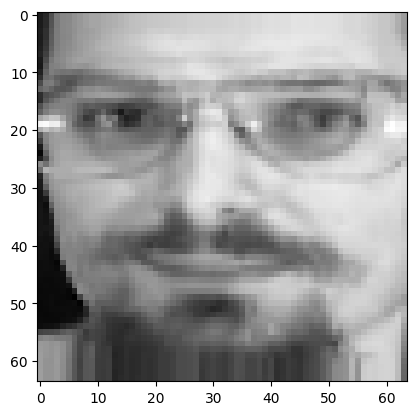

In [ ]:
plt.imshow(x_train[0], cmap = 'gray')

# Part 1: Finding a new basis

Use SVD to find a basis of the matrix representing train data





In [ ]:
X_reshape = x_train.reshape((x_train.shape[0], -1))
U, S, VT = np.linalg.svd(X_reshape, full_matrices=False)

# Part 2: Visualizing the new basis

Visualize 5 or so of the new basis vectors



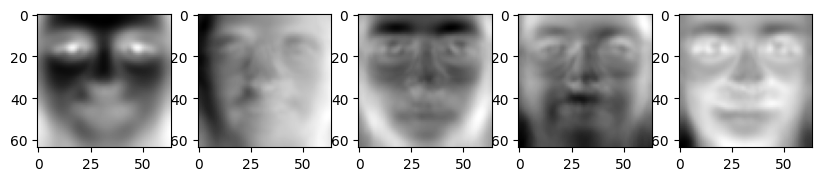

In [ ]:
nums = 5
plt.figure(figsize=(10, 20))
for i in range(nums):
    plt.subplot(1, nums, i + 1)
    basis_vector = VT[i, :]
    basis_image = basis_vector.reshape(64, 64)
    plt.imshow(basis_image, cmap='gray')
plt.show()

# Part 3: Expressing images in the new basis

Express all train and test images in this new basis

In [ ]:
x_flat = x_test.reshape((x_test.shape[0], -1))
x_train_proj = np.dot(X_reshape, VT.T)
x_test_proj = np.dot(x_flat, VT.T)

# Part 4: Visualizing reconstructed images

5 vectors, each representing an image from dataset are selected back to standard basis and then visualized.

Images obtained are similar to the original ones? Then plotted side by side


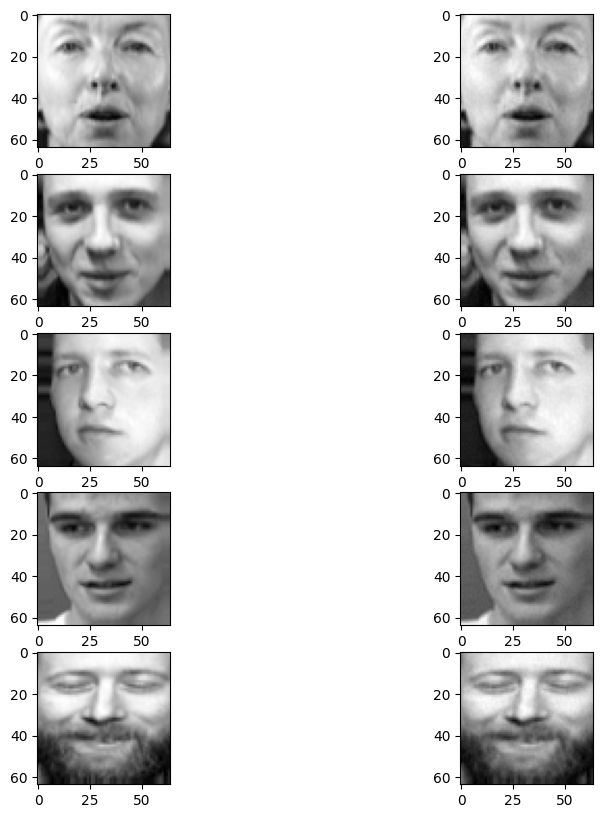

In [ ]:
images = x_test_proj[:nums]
transform_images = np.dot(images, VT)
plt.figure(figsize=(10, 10))
for i in range(nums):
  plt.subplot(nums, 2, 2*i + 1)
  og_image = x_flat[i].reshape(64, 64)
  plt.imshow(og_image, cmap='gray')

  plt.subplot(nums, 2, 2*i + 2)
  transform_image = transform_images[i].reshape(64, 64)
  plt.imshow(transform_image, cmap='gray')
plt.show()

# Part 5: Representing images in the new truncated basis

Function which expresses each image in a collection of images as vector of $r$ coordinates. Resulting vector represents the coordinates in the $r$ most prominent new basis vectors computed earlier. $r$ should be a parameter of the function.

Reduce the dimensionality of all the train and test images.




In [ ]:
def image_collection(images, VT, r):
  image_reshape = images.reshape((images.shape[0], -1))
  VT_r = VT[:r, :]
  images_top = np.dot(image_reshape, VT_r.T)
  return images_top

#x_train_proj = image_collection(x_train, VT, r)

# Part 6: Guessing a reasonable $r$

Make an informed decision about a reasonable $r$

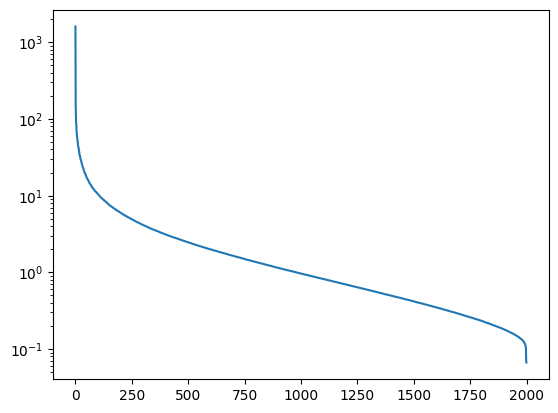

180


In [ ]:
explain_variance = np.square(S) / np.sum(np.square(S))
cumu_variance = np.cumsum(explain_variance)
plt.plot(S)
plt.yscale('log')
plt.show()

diff = np.diff(cumu_variance)
second_derivative = np.diff(diff)
reasonable_r = np.argmax(second_derivative) + 1
print(reasonable_r)

# Part 7: Visualizing the approximately reconstructed images

Pick $r$-dimensional vectors of 5 selected images from the dataset. Visualize the images they represent -- show the results for different values of $r$. Tune choice of $r$

Understand how many basis vectors are needed.

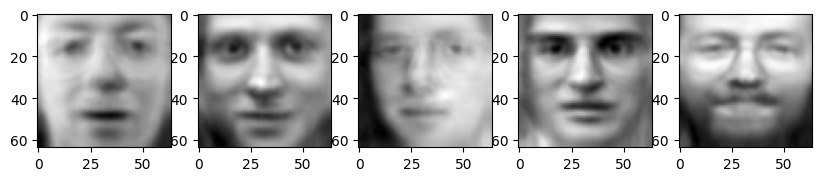

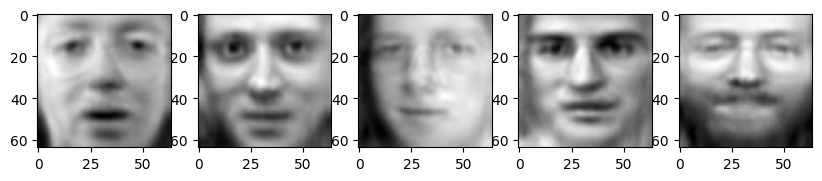

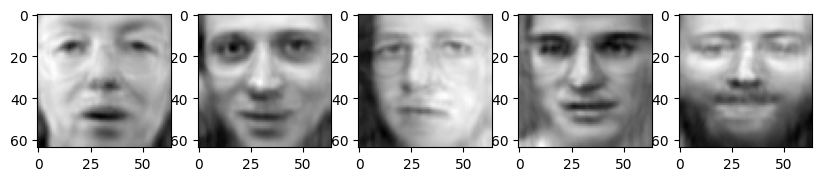

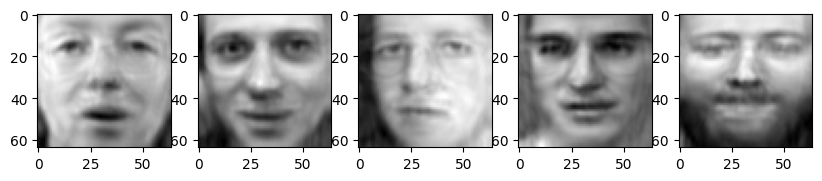

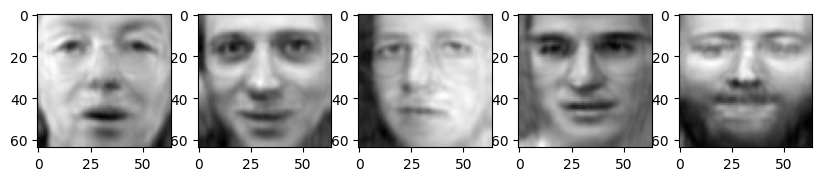

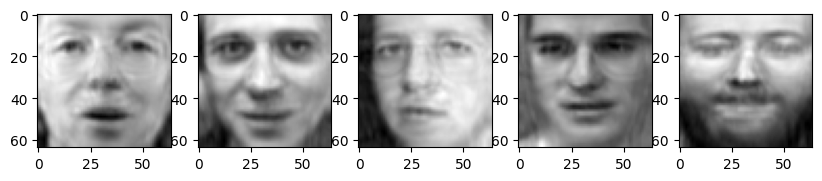

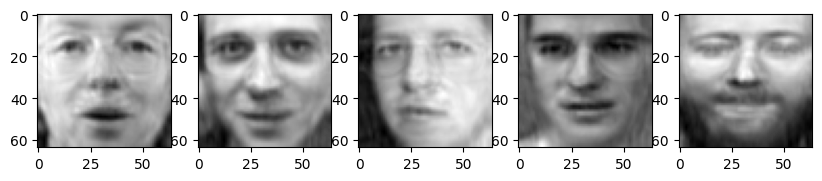

In [ ]:
def visualize_images(images, VT, R):
  nums = images.shape[0]
  images_reshape = images.reshape((nums, -1))

  for val in R:
    VT_R = VT[:val, :]
    images_dot = np.dot(images_reshape, VT_R.T)
    transform_image = np.dot(images_dot, VT_R)
    transform_reshape = transform_image.reshape((nums, 64, 64))

    _, axes = plt.subplots(1, nums, figsize=(10,10))
    for i, ax in enumerate(axes.flat):
      ax.imshow(transform_reshape[i], cmap='gray')
    plt.show()

random_r = [50, 75, reasonable_r - 30, reasonable_r - 15, 170, 200, 225]
visualize_images(x_test[:5], VT, random_r)

# Part 8: Performaing full data reduction

Perform dimensionality reduction of the entire train dataset and test dataset.

In [ ]:
x_train_proj = image_collection(x_train, VT, reasonable_r)
x_test_proj = image_collection(x_test, VT, reasonable_r)

# Part 9: Tune the parameter for good classification in the reduced space

Construct, train, test and tune a $k$-nearest neighbours classifier using the $r$-dimensional representation. Accuracy $>90\%$  on the **test set** and running time below $1$ second.

In [ ]:
from sklearn.metrics import accuracy_score
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(x_train_proj, y_train)
y_prediction = classifier.predict(x_test_proj)
accuracy = accuracy_score(y_test, y_prediction)
print(accuracy*100)

93.05


# Part 10: The final performance test



In [ ]:
import time

start_time = time.time()

x_train_proj_final = image_collection(x_train, VT, reasonable_r - 2)
x_test_proj_final = image_collection(x_test, VT, reasonable_r - 2)

classifier_final = KNeighborsClassifier(n_neighbors=2)
classifier_final.fit(x_train_proj_final, y_train)
y_prediction_final = classifier_final.predict(x_test_proj_final)
accuracy_final = accuracy_score(y_test, y_prediction_final)
print(accuracy_final*100)

end_time = time.time()

print("Time taken: ", end_time - start_time)


93.04
Time taken:  0.8256640434265137


# Part 11: Understanding Image Quality

Understand quality of the images neccesery to get 90% accuracy.



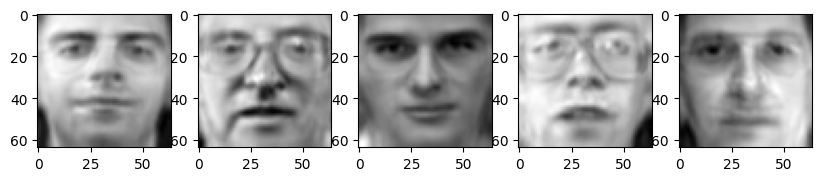

In [ ]:
visualize_images(x_test[:5], VT, [reasonable_r - 2])

#Mask?

How would the algorithm work if the faces were masked (covid-style)?

In [ ]:
mask = np.ones((64, 64), dtype=bool)
mask[32:, :] = 0

x_train_mask = x_train * mask
x_test_mask = x_test * mask

x_masked = x_train_mask.reshape((x_train_mask.shape[0], -1))
U_m, S_m, VT_m = np.linalg.svd(x_masked, full_matrices=False)

In [ ]:
x_train_mask_proj = image_collection(x_train_mask, VT_m, reasonable_r - 2)
x_test_mask_proj = image_collection(x_test_mask, VT_m, reasonable_r - 2)

classifier_mask = KNeighborsClassifier(n_neighbors=4)
classifier_mask.fit(x_train_mask_proj, y_train)
y_prediction_mask = classifier_mask.predict(x_test_mask_proj)
accuracy_mask = accuracy_score(y_test, y_prediction_mask)
print(accuracy_mask)

0.8363
